In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import networkx as nx
from statannot import add_stat_annotation
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

In [2]:
oncoprint_pd = pd.read_csv('../data/BLCA_200919/BLCA_TCGA_Cell_2017_DATA_oncoprint_mutCNAex.tsv', sep='\t')

In [3]:
oncoprint_mut_pd = oncoprint_pd[oncoprint_pd['track_type']=='MUTATIONS']
oncoprint_cna_pd = oncoprint_pd[oncoprint_pd['track_type']=='CNA']
oncoprint_mrna_pd = oncoprint_pd[oncoprint_pd['track_type']=='MRNA']

In [4]:
oncoprint_melt_pd = pd.melt(oncoprint_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_pivot = pd.pivot_table(oncoprint_melt_pd.fillna(''), index=['Case ID', 'track_name'], columns='track_type', values='event', aggfunc=lambda x: ' '.join(x))

In [5]:
print(oncoprint_melt_pd.head())
print(oncoprint_pivot.loc['TCGA-DK-A3IT'].head())

  track_name track_type       Case ID          event
0       ATF2        CNA  TCGA-DK-A3IT  Amplification
1        ATM        CNA  TCGA-DK-A3IT            NaN
2       ELK1        CNA  TCGA-DK-A3IT            NaN
3        FOS        CNA  TCGA-DK-A3IT            NaN
4       FRS2        CNA  TCGA-DK-A3IT            NaN
track_type            CNA FUSION       MRNA MUTATIONS PROTEIN
track_name                                                   
AKT1                                                         
AKT2                                                         
AKT3                                                         
ARAF                                                         
ATF2        Amplification         mRNA High                  


In [6]:
oncoprint_cna_mrna_pd = pd.concat([oncoprint_cna_pd, oncoprint_mrna_pd])
oncoprint_cna_mrna_melt_pd = pd.melt(oncoprint_cna_mrna_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
# print(oncoprint_pd.head())

gene_node_pd = pd.read_csv('../data/BLCA_200919/Grieco_gene_node_mapping.csv')
# print(gene_node_pd.head())

os_pd = pd.read_csv('../data/BLCA_200919/Overall_BLCA_TCGA_Cell_2017.csv')
dfs_pd = pd.read_csv('../data/BLCA_200919/Disease_Free_BLCA_TCGA_Cell_2017.csv')

table_original_network = pd.read_csv('../data/Grieco_table_for_original_network.tsv', sep='\t').sort_values(by='node')

In [7]:
event_count_pd = pd.merge(oncoprint_cna_mrna_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
event_count_pd.sort_values('event', ascending=False).head(20)

,Case ID,event,gene_symbol
node_name,,,
RAF,2424,230,2424
AKT,2424,180,2424
p14,808,155,808
SMAD,2424,141,2424
p38,3232,132,3232
TAOK,2424,124,2424
p70,1616,118,1616
RAS,2424,114,2424
RSK,3232,101,3232


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.090e+02
C1 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.700e+01
C2 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.200e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.300e+01
C0 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.100e+01
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.450e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f601346bef0>,
  <statannot.StatResult.StatResult at 0x7f60133adbe0>])

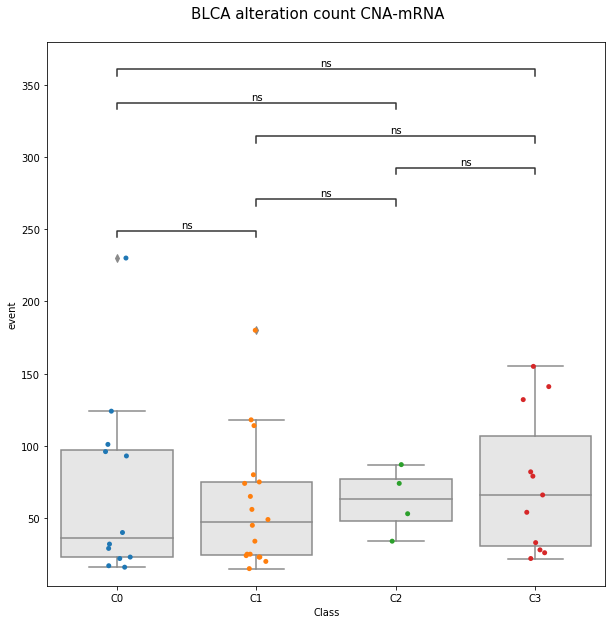

In [8]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BLCA alteration count CNA-mRNA', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C2"), ("C1", "C3"), ("C0", "C3"), ("C2", "C3"), ("C0", "C2")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

  track_name track_type       Case ID          event gene_symbol node_name  \
0       ATF2        CNA  TCGA-DK-A3IT  Amplification        ATF2      ATF2   
1       ATF2       MRNA  TCGA-DK-A3IT      mRNA High        ATF2      ATF2   
2       ATF2        CNA  TCGA-4Z-AA7R  Amplification        ATF2      ATF2   
3       ATF2       MRNA  TCGA-4Z-AA7R      mRNA High        ATF2      ATF2   
4       ATF2        CNA  TCGA-KQ-A41R  Deep Deletion        ATF2      ATF2   

   node Class  alteration  
0  ATF2    C0           1  
1  ATF2    C0           1  
2  ATF2    C0           1  
3  ATF2    C0           1  
4  ATF2    C0           1  
Class          C0   C1   C2   C3  score
Case ID                                
TCGA-2F-A9KO  1.0  5.0  0.0  3.0   -2.0
TCGA-2F-A9KP  5.0  1.0  1.0  1.0    1.0
TCGA-2F-A9KQ  4.0  0.0  0.0  2.0    2.0
TCGA-2F-A9KR  3.0  3.0  0.0  3.0    0.0
TCGA-2F-A9KT  0.0  4.0  0.0  2.0   -2.0


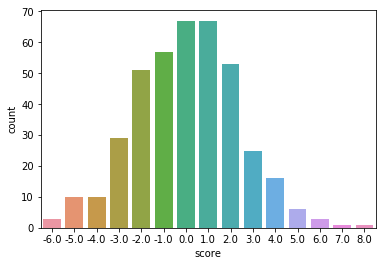

In [9]:
oncoprint_node_pd = pd.merge(oncoprint_cna_mrna_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
oncoprint_node_class_pd['alteration'] = 1
print(oncoprint_node_class_pd.head())
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)
oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

Text(0, 0.5, 'Survival')

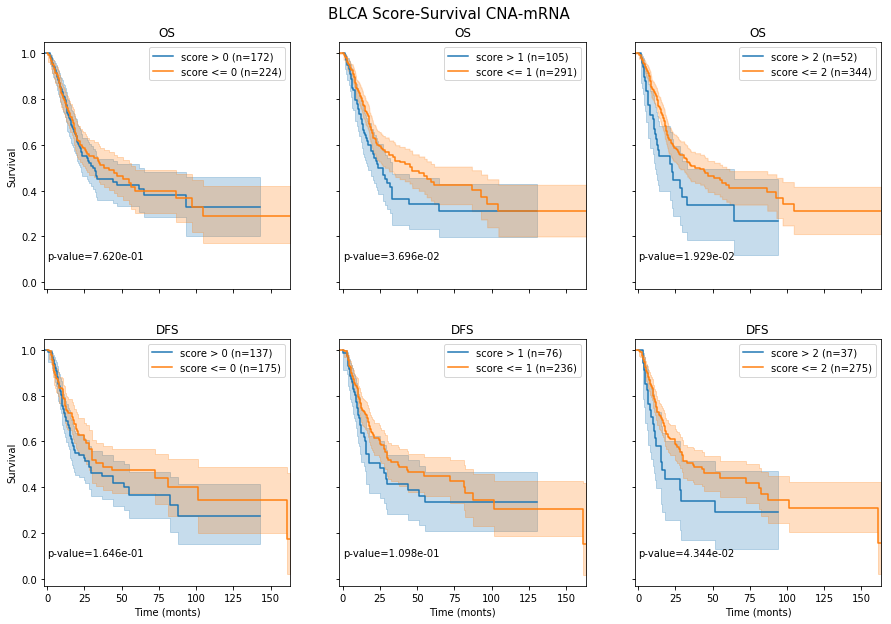

In [10]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
f.suptitle('BLCA Score-Survival CNA-mRNA', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,2]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,2]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

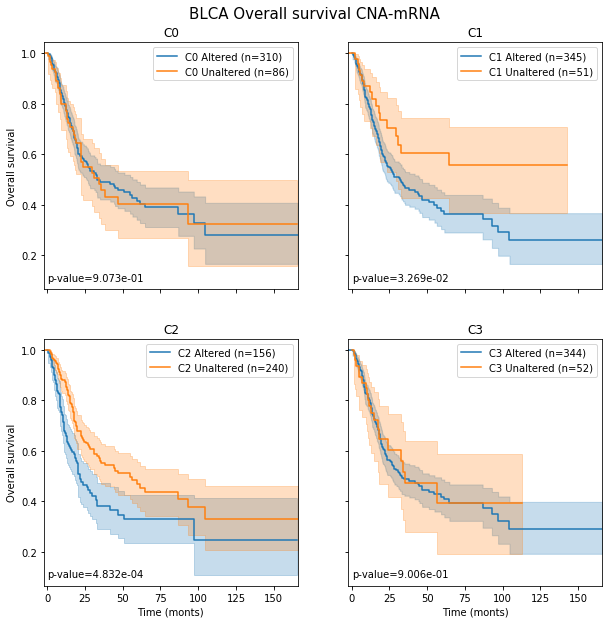

In [11]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Overall survival CNA-mRNA', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

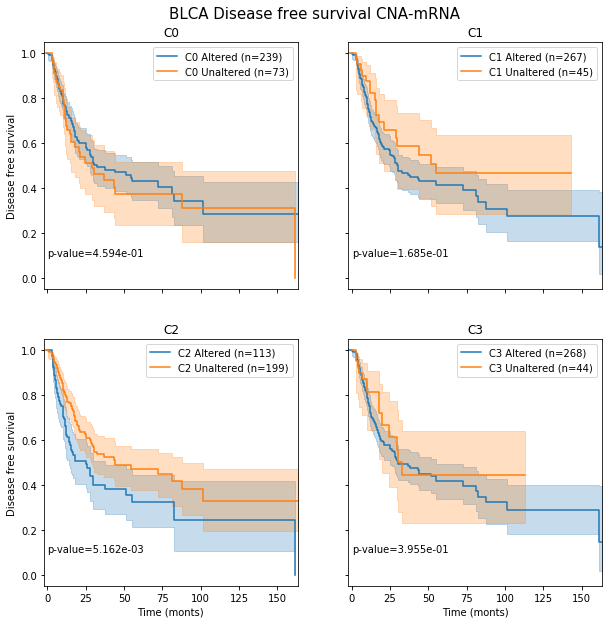

In [12]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Disease free survival CNA-mRNA', fontsize=15, y=0.93)

ax = axes[0,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

In [13]:
oncoprint_cna_mrna_mut_pd = pd.concat([oncoprint_cna_pd, oncoprint_mrna_pd, oncoprint_mut_pd])
oncoprint_cna_mrna_mut_melt_pd = pd.melt(oncoprint_cna_mrna_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')

In [14]:
event_count_pd = pd.merge(oncoprint_cna_mrna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
event_count_pd.sort_values('event', ascending=False).head(20)

,Case ID,event,gene_symbol
node_name,,,
RAF,3636,247,3636
p53,1212,223,1212
AKT,3636,194,3636
p14,1212,182,1212
SMAD,3636,160,3636
TAOK,3636,159,3636
PI3K,1212,155,1212
RAS,3636,154,3636
p38,4848,144,4848


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.185e+02
C1 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.450e+01
C2 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.800e+01
C0 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.200e+01
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.750e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f60104d29e8>,
  <statannot.StatResult.StatResult at 0x7f6010450b00>])

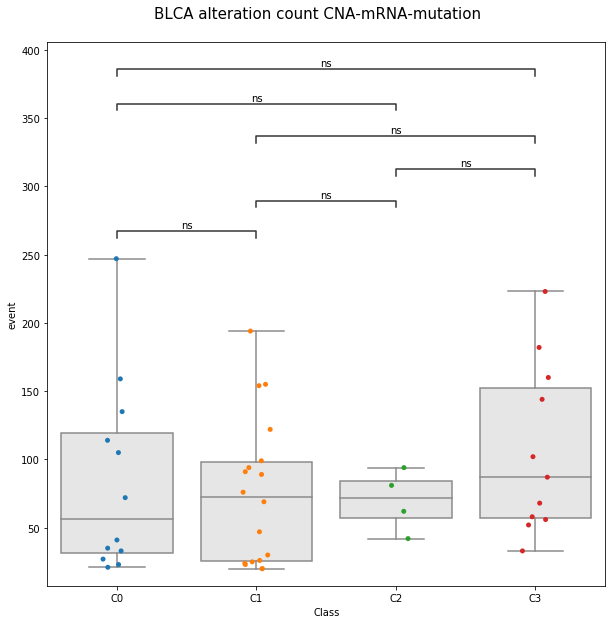

In [15]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BLCA alteration count CNA-mRNA-mutation', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C2"), ("C1", "C3"), ("C0", "C3"), ("C2", "C3"), ("C0", "C2")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

  track_name track_type       Case ID          event gene_symbol node_name  \
0       ATF2        CNA  TCGA-DK-A3IT  Amplification        ATF2      ATF2   
1       ATF2       MRNA  TCGA-DK-A3IT      mRNA High        ATF2      ATF2   
2       ATF2        CNA  TCGA-4Z-AA7R  Amplification        ATF2      ATF2   
3       ATF2       MRNA  TCGA-4Z-AA7R      mRNA High        ATF2      ATF2   
4       ATF2        CNA  TCGA-KQ-A41R  Deep Deletion        ATF2      ATF2   

   node Class  alteration  
0  ATF2    C0           1  
1  ATF2    C0           1  
2  ATF2    C0           1  
3  ATF2    C0           1  
4  ATF2    C0           1  
Class          C0   C1   C2   C3  score
Case ID                                
TCGA-2F-A9KO  2.0  7.0  0.0  3.0   -4.0
TCGA-2F-A9KP  5.0  1.0  1.0  2.0    2.0
TCGA-2F-A9KQ  4.0  1.0  0.0  3.0    2.0
TCGA-2F-A9KR  3.0  5.0  0.0  3.0   -2.0
TCGA-2F-A9KT  1.0  5.0  0.0  2.0   -3.0


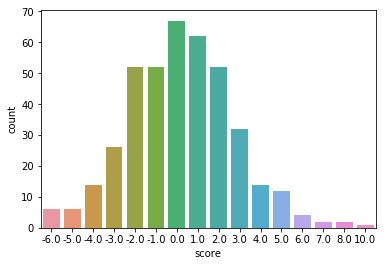

In [16]:
oncoprint_node_pd = pd.merge(oncoprint_cna_mrna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
oncoprint_node_class_pd['alteration'] = 1
print(oncoprint_node_class_pd.head())
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)
oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

Text(0, 0.5, 'Survival')

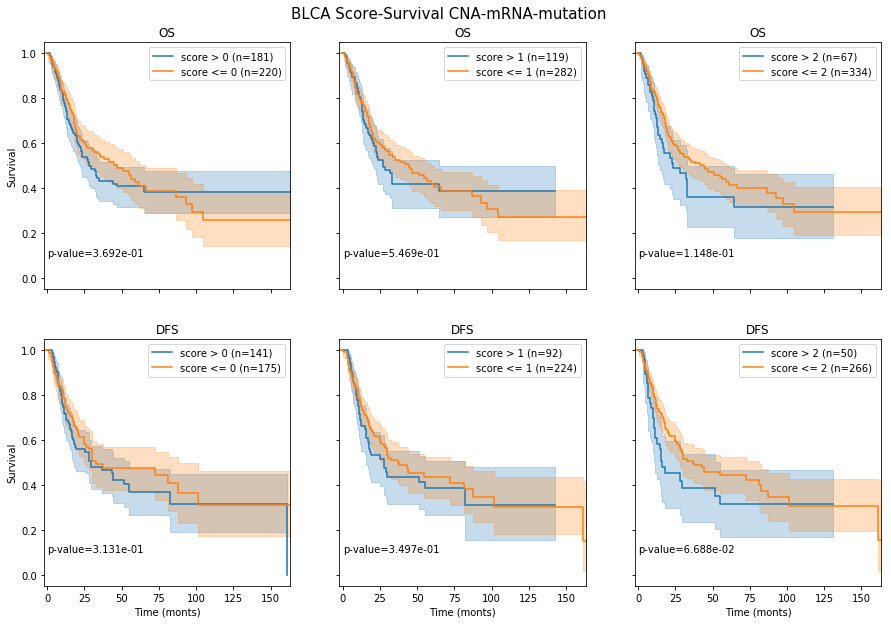

In [17]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
f.suptitle('BLCA Score-Survival CNA-mRNA-mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,2]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,2]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

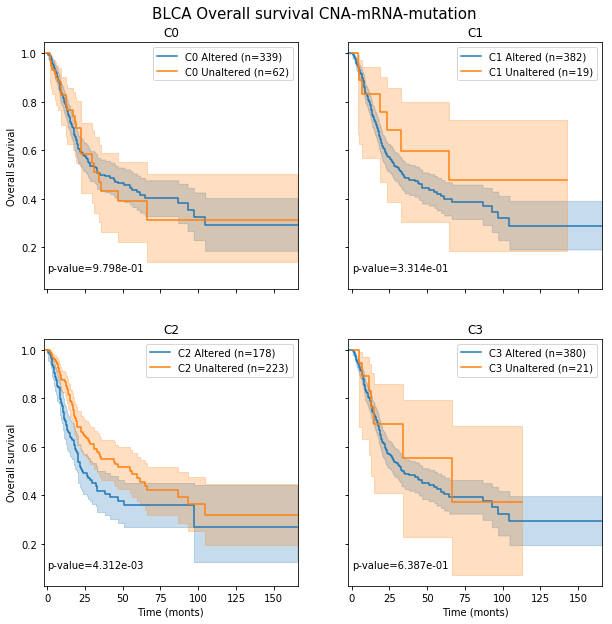

In [18]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Overall survival CNA-mRNA-mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

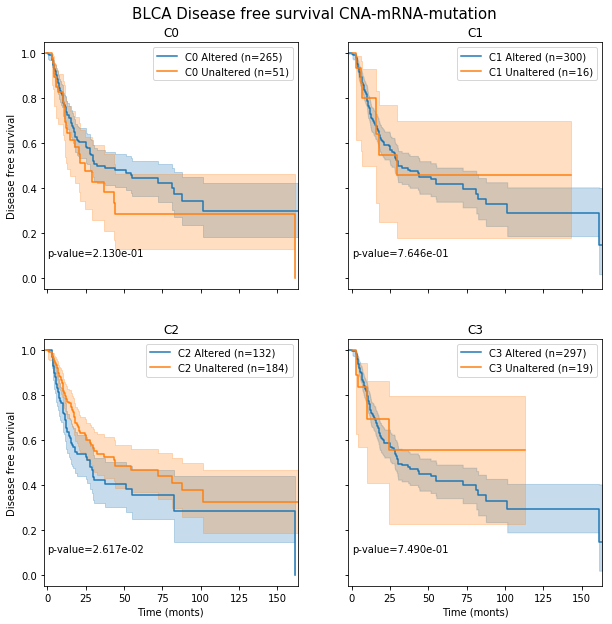

In [19]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Disease free survival CNA-mRNA-mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

In [20]:
oncoprint_driver_pd = oncoprint_cna_mrna_mut_melt_pd[oncoprint_cna_mrna_mut_melt_pd['event'].str.contains('passenger')==False]
print(oncoprint_driver_pd['event'].value_counts())
oncoprint_driver_pd = pd.merge(oncoprint_driver_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
print(oncoprint_driver_pd.head())

mRNA High                                1781
Amplification                             559
Deep Deletion                             348
Missense Mutation (putative driver)       323
mRNA Low                                  246
Truncating mutation (putative driver)     146
Inframe Mutation (putative driver)          1
Name: event, dtype: int64
  track_name track_type       Case ID          event gene_symbol node_name
0       ATF2        CNA  TCGA-DK-A3IT  Amplification        ATF2      ATF2
1       ATF2       MRNA  TCGA-DK-A3IT      mRNA High        ATF2      ATF2
2       ATF2        CNA  TCGA-4Z-AA7R  Amplification        ATF2      ATF2
3       ATF2       MRNA  TCGA-4Z-AA7R      mRNA High        ATF2      ATF2
4       ATF2        CNA  TCGA-KQ-A41R  Deep Deletion        ATF2      ATF2


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.130e+02
C1 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.100e+01
C2 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.650e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.580e-01 U_stat=6.450e+01
C0 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.200e+01
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.550e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f600ae24e80>,
  <statannot.StatResult.StatResult at 0x7f600ad9f278>])

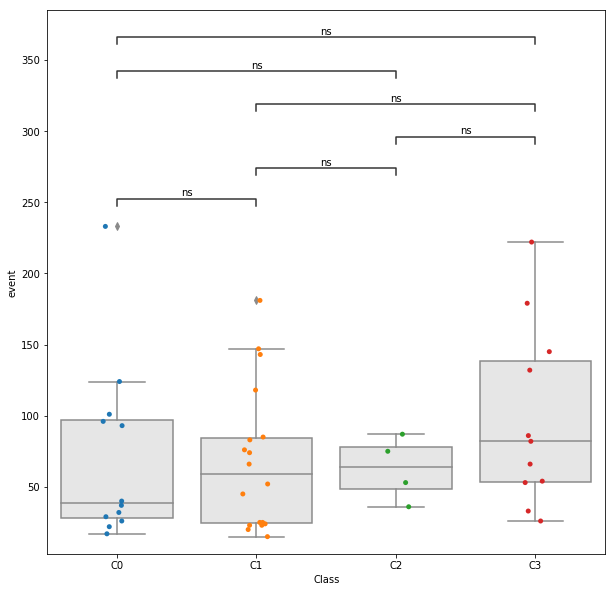

In [21]:
driver_event_count_pd = pd.merge(oncoprint_cna_mrna_mut_melt_pd[oncoprint_cna_mrna_mut_melt_pd['event'].str.contains('passenger')==False], gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
# driver_event_count_pd.sort_values('event', ascending=False).head(20)
result = pd.merge(driver_event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C2"), ("C1", "C3"), ("C0", "C3"), ("C2", "C3"), ("C0", "C2")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

In [22]:
oncoprint_driver_node_class_pd = pd.merge(oncoprint_driver_pd, table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
print(oncoprint_driver_node_class_pd.head())

  track_name track_type       Case ID          event gene_symbol node_name  \
0       ATF2        CNA  TCGA-DK-A3IT  Amplification        ATF2      ATF2   
1       ATF2       MRNA  TCGA-DK-A3IT      mRNA High        ATF2      ATF2   
2       ATF2        CNA  TCGA-4Z-AA7R  Amplification        ATF2      ATF2   
3       ATF2       MRNA  TCGA-4Z-AA7R      mRNA High        ATF2      ATF2   
4       ATF2        CNA  TCGA-KQ-A41R  Deep Deletion        ATF2      ATF2   

   node Class  
0  ATF2    C0  
1  ATF2    C0  
2  ATF2    C0  
3  ATF2    C0  
4  ATF2    C0  


In [23]:
oncoprint_driver_node_class_pd['alteration'] = 1
oncoprint_driver_reverse_controllability = pd.pivot_table(oncoprint_driver_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_driver_reverse_controllability = oncoprint_driver_reverse_controllability.fillna(0)
oncoprint_driver_reverse_controllability['score'] = oncoprint_driver_reverse_controllability['C2'] + oncoprint_driver_reverse_controllability['C3'] - oncoprint_driver_reverse_controllability['C1']
print(oncoprint_driver_reverse_controllability.head())

Class          C0   C1   C2   C3  score
Case ID                                
TCGA-2F-A9KO  1.0  6.0  0.0  3.0   -3.0
TCGA-2F-A9KP  5.0  1.0  1.0  2.0    2.0
TCGA-2F-A9KQ  4.0  1.0  0.0  3.0    2.0
TCGA-2F-A9KR  3.0  5.0  0.0  3.0   -2.0
TCGA-2F-A9KT  0.0  5.0  0.0  2.0   -3.0


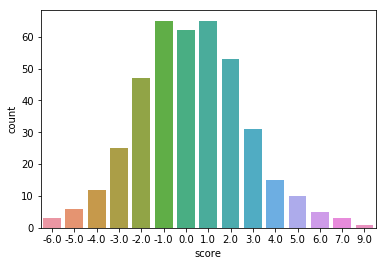

In [24]:
sns.countplot(data=oncoprint_driver_reverse_controllability, x='score')

Text(0, 0.5, 'Survival')

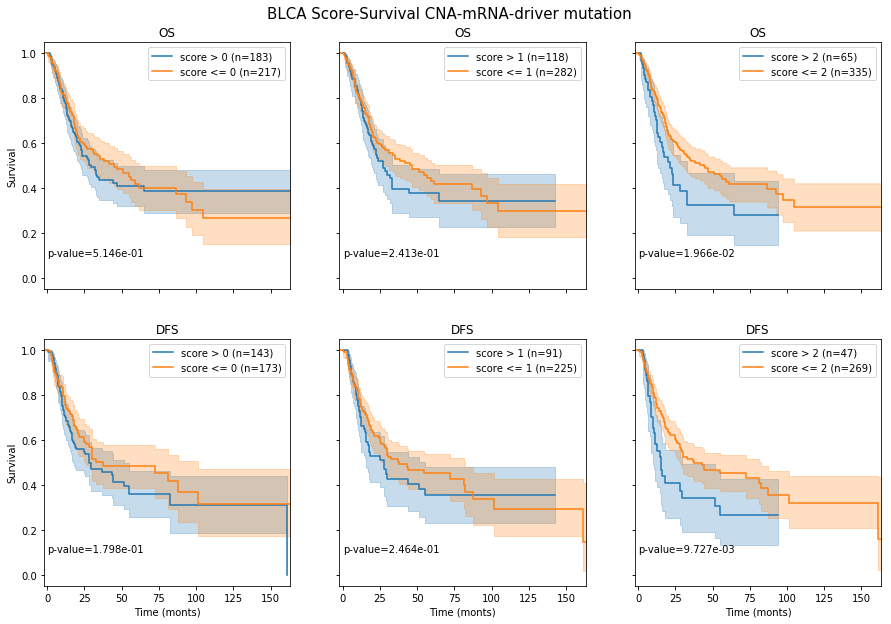

In [25]:
os_oncoprint_pd = pd.merge(oncoprint_driver_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_driver_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
f.suptitle('BLCA Score-Survival CNA-mRNA-driver mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,2]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,2]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 2.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 2 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 2 (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

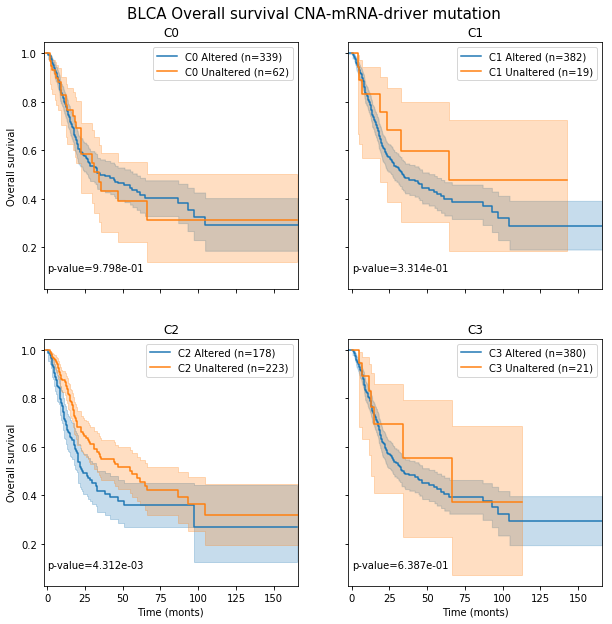

In [26]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Overall survival CNA-mRNA-driver mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

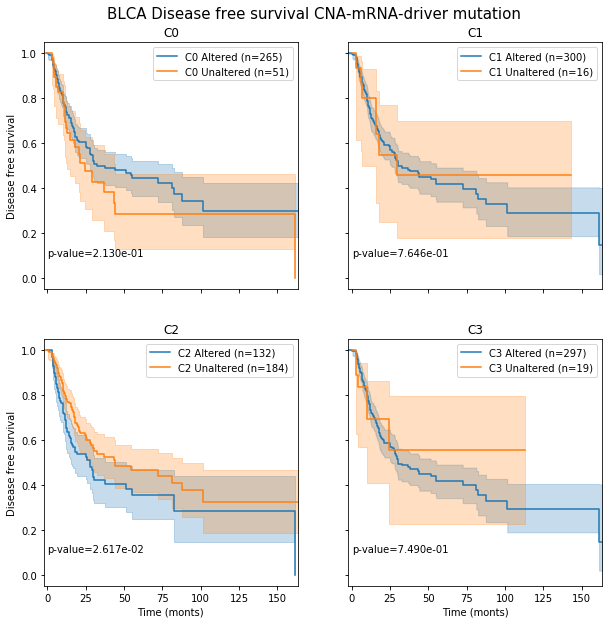

In [27]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
f.suptitle('BLCA Disease free survival CNA-mRNA-driver mutation', fontsize=15, y=0.93)

ax = axes[0,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[0,1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,0]
# data = c2_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C2'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1,1]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

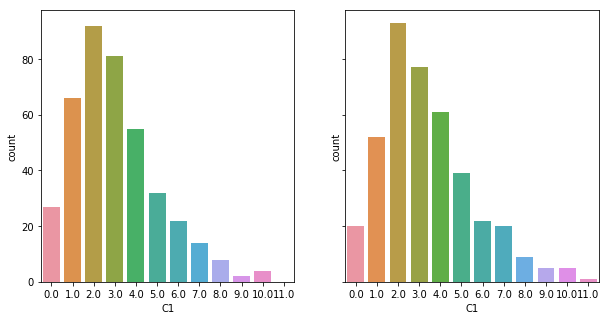

In [28]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.countplot(data=oncoprint_driver_reverse_controllability, x='C1', ax=axes[0])
sns.countplot(data=oncoprint_reverse_controllability, x='C1', ax=axes[1])

In [29]:
merge_pd = pd.merge(oncoprint_reverse_controllability, oncoprint_driver_reverse_controllability, left_index=True, right_index=True, suffixes=('w/ p', 'w/o p'))
print(merge_pd.head())

Class         C0w/ p  C1w/ p  C2w/ p  C3w/ p  scorew/ p  C0w/o p  C1w/o p  \
Case ID                                                                     
TCGA-2F-A9KO     2.0     7.0     0.0     3.0       -4.0      1.0      6.0   
TCGA-2F-A9KP     5.0     1.0     1.0     2.0        2.0      5.0      1.0   
TCGA-2F-A9KQ     4.0     1.0     0.0     3.0        2.0      4.0      1.0   
TCGA-2F-A9KR     3.0     5.0     0.0     3.0       -2.0      3.0      5.0   
TCGA-2F-A9KT     1.0     5.0     0.0     2.0       -3.0      0.0      5.0   

Class         C2w/o p  C3w/o p  scorew/o p  
Case ID                                     
TCGA-2F-A9KO      0.0      3.0        -3.0  
TCGA-2F-A9KP      1.0      2.0         2.0  
TCGA-2F-A9KQ      0.0      3.0         2.0  
TCGA-2F-A9KR      0.0      3.0        -2.0  
TCGA-2F-A9KT      0.0      2.0        -3.0  


In [30]:
merge_pd.sum()

Class
C0w/ p        1012.0
C1w/ p        1357.0
C2w/ p         279.0
C3w/ p        1165.0
scorew/ p       87.0
C0w/o p        850.0
C1w/o p       1225.0
C2w/o p        251.0
C3w/o p       1078.0
scorew/o p     104.0
dtype: float64

  track_name track_type       Case ID                                   event  \
0     MAP3K4  MUTATIONS  TCGA-DK-A3IT  Missense Mutation (putative passenger)   
1     MAP3K4  MUTATIONS  TCGA-UY-A9PF  Missense Mutation (putative passenger)   
2     MAP3K4  MUTATIONS  TCGA-MV-A51V  Missense Mutation (putative passenger)   
3     MAP3K4  MUTATIONS  TCGA-XF-AAML  Missense Mutation (putative passenger)   
4     MAP3K4  MUTATIONS  TCGA-BT-A3PK  Missense Mutation (putative passenger)   

  gene_symbol node_name  
0      MAP3K4      MTK1  
1      MAP3K4      MTK1  
2      MAP3K4      MTK1  
3      MAP3K4      MTK1  
4      MAP3K4      MTK1  


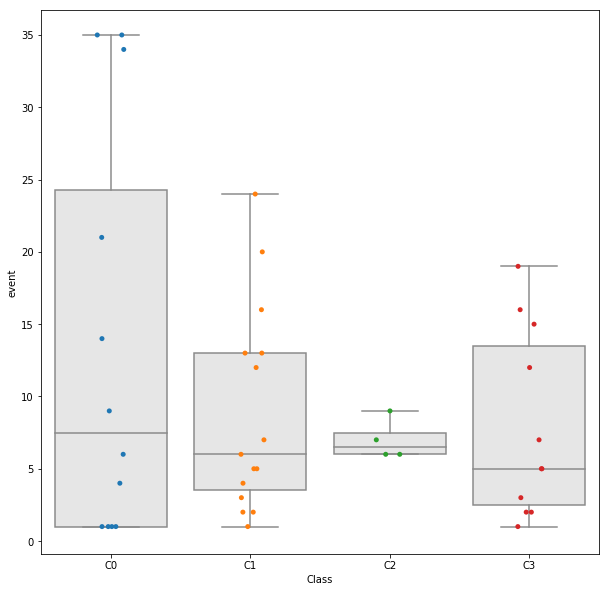

In [31]:
passenger_pd = oncoprint_cna_mrna_mut_melt_pd[oncoprint_cna_mrna_mut_melt_pd['event'].str.contains('passenger')==True]
passenger_pd = pd.merge(passenger_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
print(passenger_pd.head())
passenger_event_count_pd = pd.merge(oncoprint_cna_mrna_mut_melt_pd[oncoprint_cna_mrna_mut_melt_pd['event'].str.contains('passenger')==True], gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
# driver_event_count_pd.sort_values('event', ascending=False).head(20)
result = pd.merge(passenger_event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

In [32]:
oncoprint_cna_mut_pd = pd.concat([oncoprint_cna_pd, oncoprint_mut_pd])
oncoprint_cna_mut_melt_pd = pd.melt(oncoprint_cna_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_node_pd = pd.merge(oncoprint_cna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
oncoprint_node_class_pd['alteration'] = 1
# print(oncoprint_node_class_pd.head())
oncoprint_wo_mrna_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_wo_mrna_reverse_controllability = oncoprint_wo_mrna_reverse_controllability.fillna(0)
oncoprint_wo_mrna_reverse_controllability['score'] = oncoprint_wo_mrna_reverse_controllability['C2'] + oncoprint_wo_mrna_reverse_controllability['C3'] - oncoprint_wo_mrna_reverse_controllability['C1']
print(oncoprint_wo_mrna_reverse_controllability.head())

oncoprint_node_pd = pd.merge(oncoprint_cna_mrna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
oncoprint_node_class_pd['alteration'] = 1
# print(oncoprint_node_class_pd.head())
oncoprint_w_mrna_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_w_mrna_reverse_controllability = oncoprint_w_mrna_reverse_controllability.fillna(0)
oncoprint_w_mrna_reverse_controllability['score'] = oncoprint_w_mrna_reverse_controllability['C2'] + oncoprint_w_mrna_reverse_controllability['C3'] - oncoprint_w_mrna_reverse_controllability['C1']
print(oncoprint_w_mrna_reverse_controllability.head())

Class          C0   C1   C2   C3  score
Case ID                                
TCGA-2F-A9KO  1.0  3.0  0.0  1.0   -2.0
TCGA-2F-A9KP  3.0  0.0  1.0  1.0    2.0
TCGA-2F-A9KQ  1.0  1.0  0.0  2.0    1.0
TCGA-2F-A9KR  2.0  3.0  0.0  1.0   -2.0
TCGA-2F-A9KT  1.0  1.0  0.0  1.0    0.0
Class          C0   C1   C2   C3  score
Case ID                                
TCGA-2F-A9KO  2.0  7.0  0.0  3.0   -4.0
TCGA-2F-A9KP  5.0  1.0  1.0  2.0    2.0
TCGA-2F-A9KQ  4.0  1.0  0.0  3.0    2.0
TCGA-2F-A9KR  3.0  5.0  0.0  3.0   -2.0
TCGA-2F-A9KT  1.0  5.0  0.0  2.0   -3.0


In [33]:
altered_mrna_patient = set(oncoprint_w_mrna_reverse_controllability[oncoprint_w_mrna_reverse_controllability['C1'] > 0].index).intersection(set(oncoprint_wo_mrna_reverse_controllability[oncoprint_wo_mrna_reverse_controllability['C1'] == 0].index))
print(altered_mrna_patient)

{'TCGA-DK-AA6W', 'TCGA-2F-A9KP', 'TCGA-BL-A13J', 'TCGA-ZF-A9R9', 'TCGA-FD-A43U', 'TCGA-YF-AA3M', 'TCGA-4Z-AA7S', 'TCGA-DK-AA6U', 'TCGA-K4-A5RH', 'TCGA-YC-A9TC', 'TCGA-FD-A3B8', 'TCGA-SY-A9G0', 'TCGA-BT-A20N', 'TCGA-DK-A3IM', 'TCGA-BT-A3PK', 'TCGA-GU-A42P', 'TCGA-KQ-A41N', 'TCGA-KQ-A41S', 'TCGA-K4-A5RI', 'TCGA-E7-A6ME', 'TCGA-GV-A3QF', 'TCGA-FD-A3N6', 'TCGA-HQ-A2OF', 'TCGA-BT-A20U', 'TCGA-CU-A3QU', 'TCGA-FD-A62N', 'TCGA-DK-A2I2', 'TCGA-4Z-AA7R', 'TCGA-E7-A97Q', 'TCGA-GU-A762', 'TCGA-UY-A8OB', 'TCGA-LC-A66R', 'TCGA-XF-AAMT', 'TCGA-GU-A766', 'TCGA-PQ-A6FI', 'TCGA-BL-A3JM', 'TCGA-FD-A6TH', 'TCGA-DK-A3IL', 'TCGA-DK-A3IV', 'TCGA-BT-A3PJ', 'TCGA-XF-A9SW', 'TCGA-E7-A541', 'TCGA-ZF-A9R0', 'TCGA-GD-A3OS', 'TCGA-GV-A3QH', 'TCGA-XF-A9SZ', 'TCGA-FD-A6TF', 'TCGA-XF-A9T3', 'TCGA-XF-AAN4', 'TCGA-BT-A20X', 'TCGA-5N-A9KM', 'TCGA-XF-AAMR', 'TCGA-FD-A3SS', 'TCGA-XF-A9SK', 'TCGA-ZF-AA4N', 'TCGA-FD-A3N5', 'TCGA-XF-A9T6', 'TCGA-BL-A13I', 'TCGA-GC-A3RD', 'TCGA-XF-A8HH', 'TCGA-PQ-A6FN', 'TCGA-BT-A20V', 'TCGA-F

In [34]:
len(altered_mrna_patient)

79

In [35]:
altered_mrna_patient_wo_mrna_pd = oncoprint_wo_mrna_reverse_controllability.loc[altered_mrna_patient]
# altered_mrna_patient_wo_mrna_pd['C2C3'] = altered_mrna_patient_wo_mrna_pd['C2'] + altered_mrna_patient_wo_mrna_pd['C3']

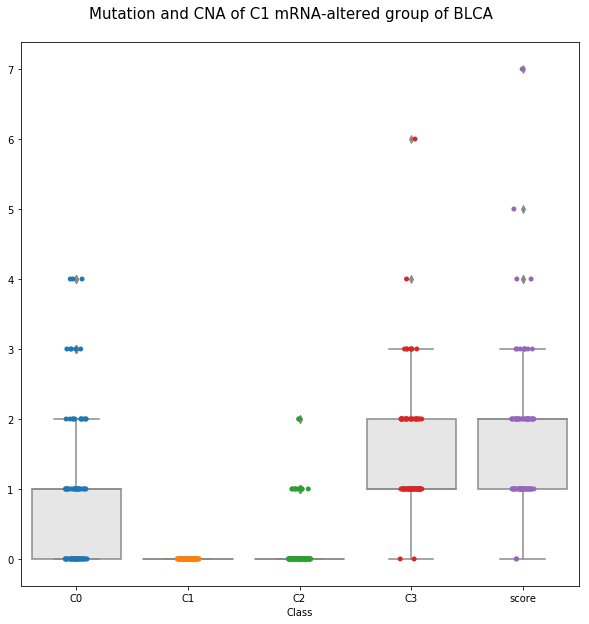

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('Mutation and CNA of C1 mRNA-altered group of BLCA', fontsize=15, y=0.93)
ax = sns.stripplot(data=altered_mrna_patient_wo_mrna_pd)
ax = sns.boxplot(data=altered_mrna_patient_wo_mrna_pd, color='.9', ax=ax)

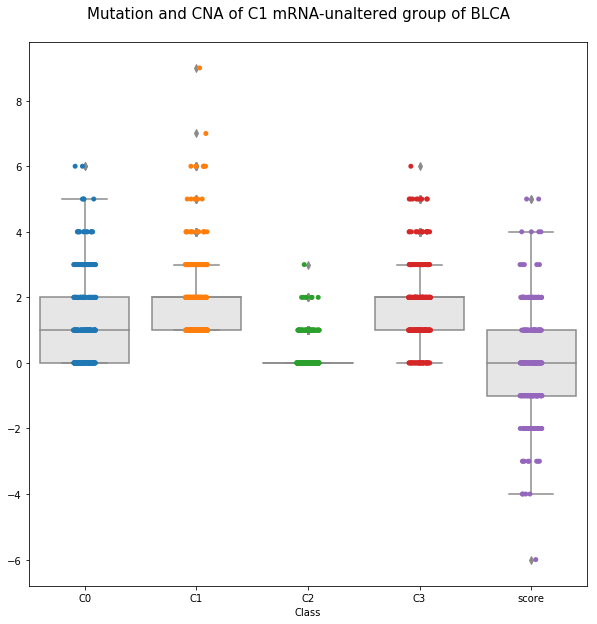

In [37]:
unaltered_mrna_patient = set(oncoprint_w_mrna_reverse_controllability[oncoprint_w_mrna_reverse_controllability['C1'] > 0].index).intersection(set(oncoprint_wo_mrna_reverse_controllability[oncoprint_wo_mrna_reverse_controllability['C1'] > 0].index))
unaltered_mrna_patient_wo_mrna_pd = oncoprint_wo_mrna_reverse_controllability.loc[unaltered_mrna_patient]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('Mutation and CNA of C1 mRNA-unaltered group of BLCA', fontsize=15, y=0.93)
ax = sns.stripplot(data=unaltered_mrna_patient_wo_mrna_pd)
ax = sns.boxplot(data=unaltered_mrna_patient_wo_mrna_pd, color='.9', ax=ax)